In [1]:
import sys
sys.path.insert(1, "/home/gemeinl/code/brainfeatures/")

In [2]:
import numpy as np
import time
import pandas as pd

In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score

In [4]:
from pyriemann.utils.mean import mean_covariance
from pyriemann.tangentspace import TangentSpace

In [5]:
from brainfeatures.data_set.tuh_abnormal import TuhAbnormal
from brainfeatures.utils.data_util import reject_windows_with_outliers, split_into_epochs

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns
sns.set(color_codes=True)

In [8]:
fs =20
plt.rcParams.update({"font.size": fs})
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rc('axes',labelsize=fs)

show full tangent space covariance matrices averaged by class

In [9]:
electrodes = ['A1', 'A2', 'C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',
                     'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6']

In [10]:
covs = np.load("/home/gemeinl/data/covs/mean_train_covs.npy")

In [11]:
y = np.load("/home/gemeinl/data/covs/train_pathology_labels_without_822.npy")

In [12]:
# pyriemann ts uses triu!
ts = TangentSpace()
ts_covs = ts.fit_transform(covs)

In [13]:
ts_covs.shape

(2716, 231)

ts_covs = ts_covs - np.min(ts_covs, axis=1, keepdims=True)
ts_covs = ts_covs / np.max(ts_covs, axis=1, keepdims=True)

In [14]:
ts_covs.shape

(2716, 231)

In [15]:
ts_patho_covs = ts_covs[y]
ts_non_patho_covs = ts_covs[~y]

In [16]:
len(ts_patho_covs), len(ts_non_patho_covs)

(1345, 1371)

In [17]:
def find_n(flattened_length):
    a = 1/2
    b = 1/2
    c = -flattened_length
    x1 = (-b + np.sqrt(b*b - 4*a*c)) / (2*a)
    x2 = (-b - np.sqrt(b*b - 4*a*c)) / (2*a)
    res = np.max([x1, x2])
    assert res%1 == 0
    return int(res)

In [18]:
def square_matrix_from_flat_triu(flat_triu):
    n = find_n(len(flat_triu))
    # https://stackoverflow.com/questions/17527693/transform-the-upper-lower-triangular-part-of-a-symmetric-matrix-2d-array-into?lq=1
    new = np.zeros((n, n))
    for i, j in enumerate(zip(*np.triu_indices_from(new))):
        new[j] = flat_triu[i]
        new[j[1], j[0]] = flat_triu[i]
    return new

In [19]:
square_ts_patho_covs = [square_matrix_from_flat_triu(cov) for cov in ts_patho_covs]
square_ts_non_patho_covs = [square_matrix_from_flat_triu(cov) for cov in ts_non_patho_covs]

In [20]:
mean_square_ts_patho_covs = np.mean(square_ts_patho_covs, axis=0)
mean_square_ts_non_patho_covs = np.mean(square_ts_non_patho_covs, axis=0)

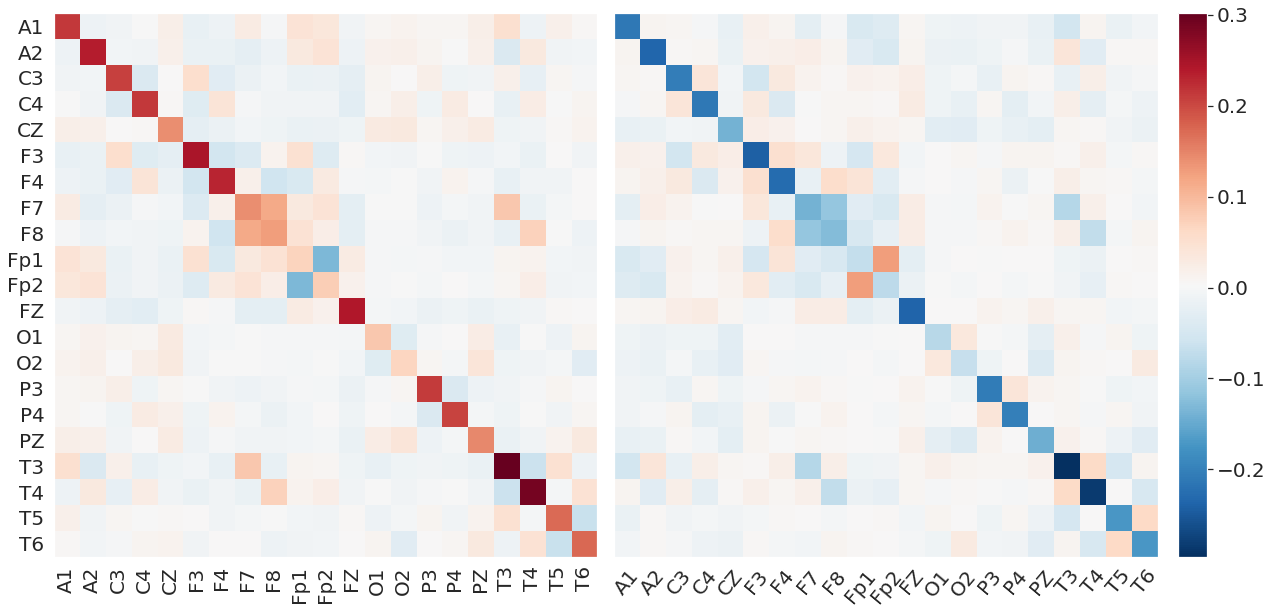

In [21]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)

vmin = np.min([np.min(mean_square_ts_patho_covs), np.min(mean_square_ts_non_patho_covs)])
vmax = np.max([np.max(mean_square_ts_patho_covs), np.max(mean_square_ts_non_patho_covs)])

ax = ax_arr[0]
im = ax.imshow(mean_square_ts_patho_covs, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax.set_xticklabels(electrodes, rotation=90)
ax.grid()

ax = ax_arr[1]
im = ax.imshow(mean_square_ts_non_patho_covs, cmap="RdBu_r", vmin=vmin, vmax=vmax)

ax.set_xticks(np.arange(len(electrodes)))
ax.set_xticklabels(electrodes, rotation=50)
ax.set_yticks(np.arange(len(electrodes)))
ax.set_yticklabels(electrodes)
ax.grid()

plt.subplots_adjust(wspace=.01)
cax = fig.add_axes([.91, .125, .02, 0.755])
plt.colorbar(im, cax=cax)

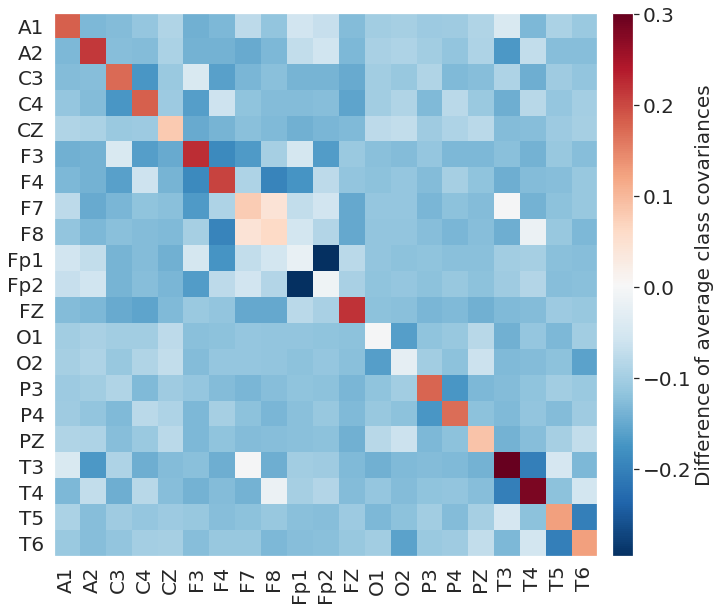

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
diff = mean_square_ts_patho_covs-mean_square_ts_non_patho_covs
vmin = np.min(diff)
vmax = np.max(diff)
ax.imshow(diff,cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(len(electrodes)))
ax.set_xticklabels(electrodes, rotation=90)
ax.set_yticks(np.arange(len(electrodes)))
ax.set_yticklabels(electrodes)
ax.grid()
cax = fig.add_axes([.91, .125, .03, 0.755])
plt.colorbar(im, cax=cax, label="Difference of average class covariances")

fig.savefig("./differenve_of_average_covariances.pdf", bbox_inches="tight")